Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2023/2024  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Druga laboratorijska vježba: Linearni diskriminativni modeli i logistička regresija

*Verzija: 1.1 (ispravljena greška u tekstu prvog zadatka)  
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2023 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **5. studenog 2023. u 23:59h**

------------------------------

### Pravila predaje
Predajom vježbe potvrđujete sljedeće točke:
1. Niste od drugoga primili pomoć pri rješavanju vježbe;
2. Atribuirali ste dijelove koda koji su preuzeti s interneta referencirajući ih u komentarima;
3. Niste koristili dijelove koda s interneta koji su specifični za laboratorijsku vježbu;
4. Niste koristili UI-asistente za kodiranje kao npr. GitHub Copilot (uključivo alate generativne UI, kao što je ChatGPT).

**Povreda bilo kojeg od gornjih pravila smatra se prekršajem te povlači akademske sankcije.**

### Upute

Druga laboratorijska vježba sastoji se od šest zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%pylab inline

C:\Users\matij\AppData\Roaming\Python\Python311\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Linearna regresija kao klasifikator

U prethodnoj laboratorijskoj vježbi koristili smo model linearne regresije za, naravno, regresiju. Međutim, model linearne regresije može se koristiti i za **klasifikaciju**. Iako zvuči pomalo kontraintuitivno, zapravo je dosta jednostavno. Naime, cilj je naučiti funkciju $f(\mathbf{x})$ koja za pozitivne primjere predviđa vrijednost $1$, dok za negativne primjere predviđa vrijednost $0$. U tom slučaju, funkcija $f(\mathbf{x})=0.5$ predstavlja granicu između klasa, tj. primjeri za koje vrijedi $h(\mathbf{x})\geq 0.5$ klasificiraju se kao pozitivni, dok se ostali klasificiraju kao negativni.

Klasifikacija pomoću linearne regresije implementirana je u razredu [`RidgeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html). U sljedećim podzadatcima **istrenirajte** taj model na danim podatcima i **prikažite** dobivenu granicu između klasa. Pritom isključite regularizaciju ($\alpha = 0$, odnosno `alpha=0`). Također i ispišite **točnost** vašeg klasifikacijskog modela (smijete koristiti funkciju [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)). Skupove podataka vizualizirajte korištenjem pomoćne funkcije ``plot_clf_problem(X, y, h=None)`` koja je dana na početku ove bilježnice. `X` i `y` predstavljaju ulazne primjere i oznake, dok `h` predstavlja funkciju predikcije modela (npr. `model.predict`). 

U ovom zadatku cilj je razmotriti kako se klasifikacijski model linearne regresije ponaša na linearno odvojim i neodvojivim podatcima.

In [3]:
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.metrics import accuracy_score

### (a)

Prvo, isprobajte *ugrađeni* model na linearno odvojivom skupu podataka `seven` ($N=7$).

In [4]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

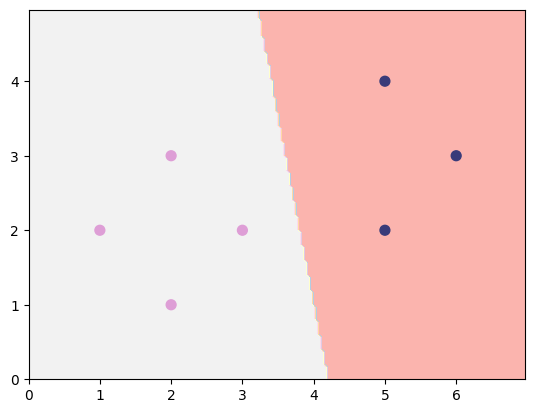

In [5]:
# Vaš kôd ovdje
clf = RidgeClassifier(alpha=0).fit(seven_X, seven_y)
y_pred = clf.predict(seven_X)
plot_2d_clf_problem(seven_X,seven_y, lambda x : clf.predict(x) >= 0.5)

Kako bi se uvjerili da se u isprobanoj implementaciji ne radi o ničemu doli o običnoj linearnoj regresiji, napišite kôd koji dolazi do jednakog rješenja korištenjem isključivo razreda [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Funkciju za predikciju, koju predajete kao treći argument `h` funkciji `plot_2d_clf_problem`, možete definirati lambda-izrazom: `lambda x : model.predict(x) >= 0.5`.

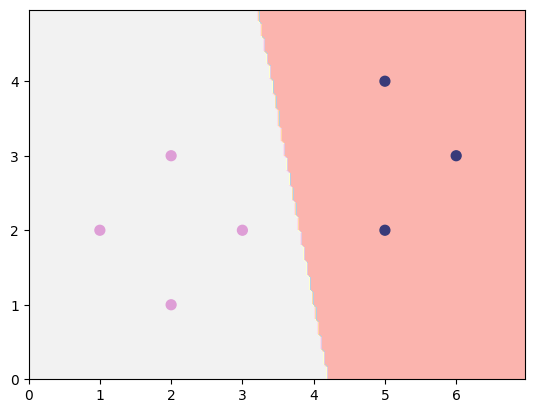

In [6]:
# Vaš kôd ovdje
lreg = LinearRegression().fit(seven_X,seven_y)
plot_2d_clf_problem(seven_X,seven_y,lambda x: lreg.predict(x) >= 0.5)

**Q:** Kako bi bila definirana granica između klasa ako bismo koristili oznake klasa $-1$ i $1$ umjesto $0$ i $1$?

### (b)  

Probajte isto na linearno odvojivom skupu podataka `outlier` ($N=8$):

In [7]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

0.875


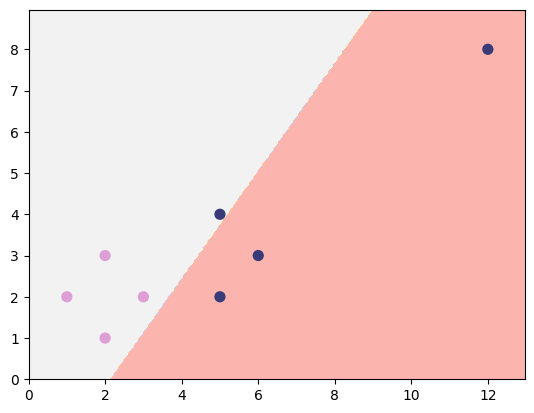

In [8]:
# Vaš kôd ovdje
clf_b = RidgeClassifier(alpha=0).fit(outlier_X, outlier_y)
y_pred = clf_b.predict(outlier_X)
print(accuracy_score(outlier_y,y_pred))
plot_2d_clf_problem(outlier_X,outlier_y, lambda x : clf_b.predict(x) >= 0.5)

**Q:** Zašto model ne ostvaruje potpunu točnost iako su podatci linearno odvojivi?

### (c)  

Završno, probajte isto na linearno neodvojivom skupu podataka `unsep` ($N=8$):

In [9]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

0.875


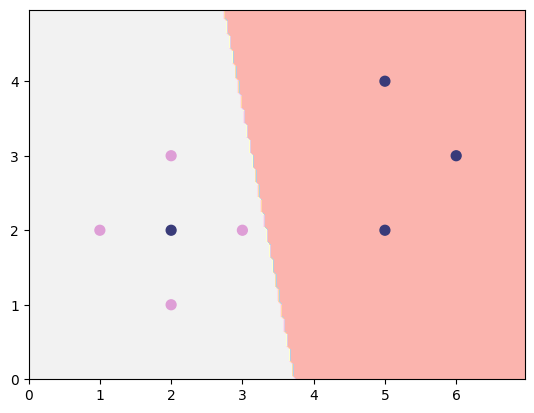

In [10]:
# Vaš kôd ovdje
clf_c = RidgeClassifier(alpha=0).fit(unsep_X, unsep_y)
y_pred = clf_c.predict(unsep_X)
print(accuracy_score(unsep_y,y_pred))
plot_2d_clf_problem(unsep_X,unsep_y, lambda x : clf_c.predict(x) >= 0.5)

**Q:** Očito je zašto model nije u mogućnosti postići potpunu točnost na ovom skupu podataka. Međutim, smatrate li da je problem u modelu ili u podacima? Argumentirajte svoj stav.

### 2. Višeklasna klasifikacija

Postoji više načina kako se binarni klasifikatori mogu se upotrijebiti za višeklasnu klasifikaciju. Najčešće se koristi shema tzv. **jedan-naspram-ostali** (engl. *one-vs-rest*, OVR), u kojoj se trenira po jedan klasifikator $h_j$ za svaku od $K$ klasa. Svaki klasifikator $h_j$ trenira se da razdvaja primjere klase $j$ od primjera svih drugih klasa, a primjer se klasificira u klasu $j$ za koju je $h_j(\mathbf{x})$ maksimalan.

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte slučajan dvodimenzijski skup podataka od tri klase i prikažite ga koristeći funkciju `plot_2d_clf_problem`. Radi jednostavnosti, pretpostavite da nema redundantnih značajki te da je svaka od klasa "zbijena" upravo u jednu grupu.

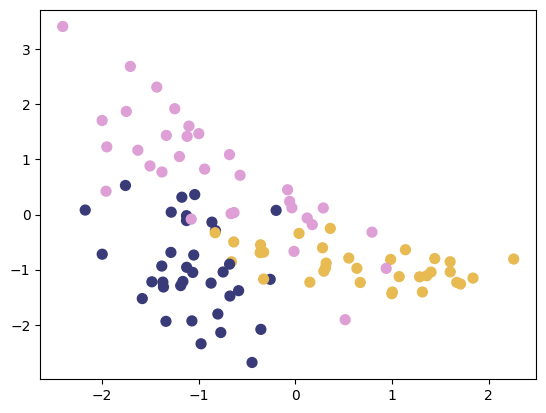

In [11]:
from sklearn.datasets import make_classification

# Vaš kôd ovdje
X, y = make_classification(n_features=2,n_redundant=0,n_classes=3,n_clusters_per_class=1)
plot_2d_clf_problem(X,y)

Trenirajte tri binarna klasifikatora, $h_1$, $h_2$ i $h_3$ te prikažite granice između klasa (tri grafikona). Zatim definirajte $h(\mathbf{x})=\mathrm{argmax}_j h_j(\mathbf{x})$  (napišite svoju funkciju `predict` koja to radi) i prikažite granice između klasa za taj model. Zatim se uvjerite da biste identičan rezultat dobili izravno primjenom modela `RidgeClassifier`, budući da taj model za višeklasan problem zapravo interno implementira shemu jedan-naspram-ostali.

**Q:** Alternativna shema jest ona zvana **jedan-naspram-jedan** (engl, *one-vs-one*, OVO). Koja je prednost sheme OVR nad shemom OVO? A obratno?

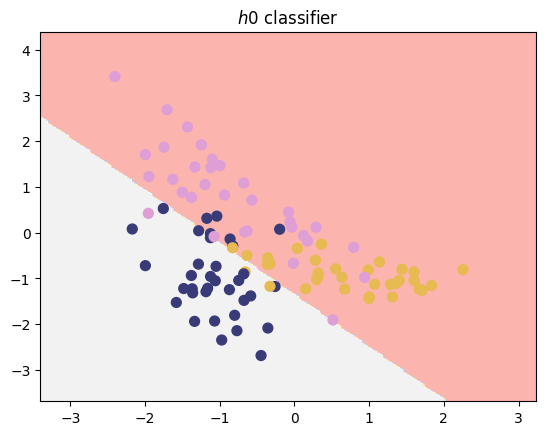

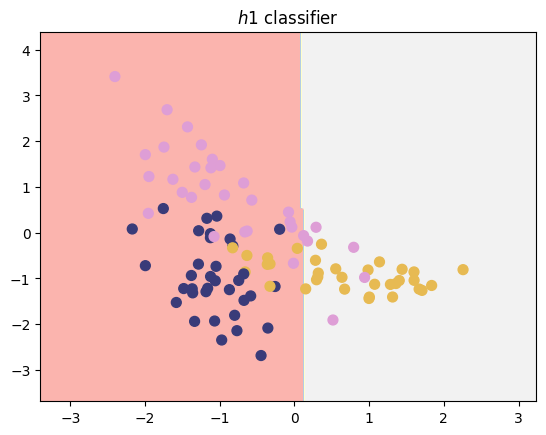

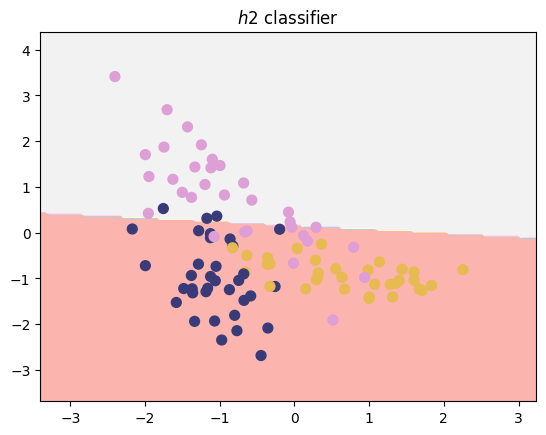

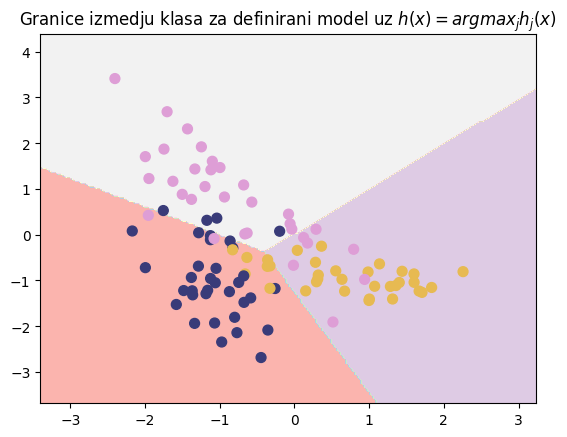

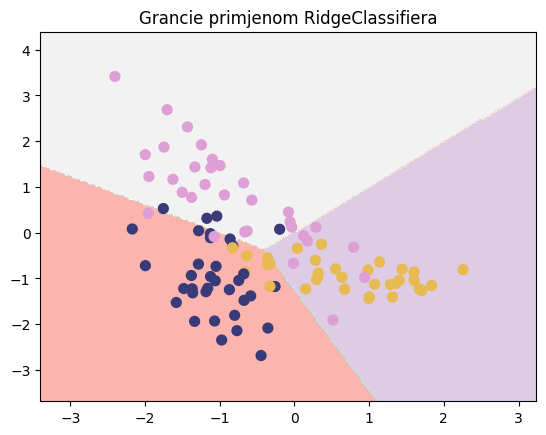

In [12]:
# Vaš kôd ovdje

classifiers = []
for i in range(0,3):
  y_temp = y.copy()
  for j,element in enumerate(y_temp):
    if(element != i):
      y_temp[j] = 0
    else:
      y_temp[j] = 1
  rcl = LinearRegression().fit(X,y_temp)
  classifiers.append(rcl)
  plot_2d_clf_problem(X,y, lambda x : rcl.predict(x) >= 0.5)
  plt.title("$h" + str(i) + "$ classifier")
  plt.show()
h_argmax = lambda x: np.argmax([classifiers[0].predict(x.reshape(1, -1)), classifiers[1].predict(x.reshape(1, -1)), classifiers[2].predict(x.reshape(1, -1))])
plot_2d_clf_problem(X, y, h_argmax)
plt.title('Granice izmedju klasa za definirani model uz $h(x) = argmax_jh_j(x)$')
plt.show()

rcl = RidgeClassifier(alpha=0).fit(X,y)
plot_2d_clf_problem(X, y, lambda x : rcl.predict(x.reshape(1,-1)))
plt.title('Grancie primjenom RidgeClassifiera')
plt.show()

### 3. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

<function matplotlib.pyplot.show(close=None, block=None)>

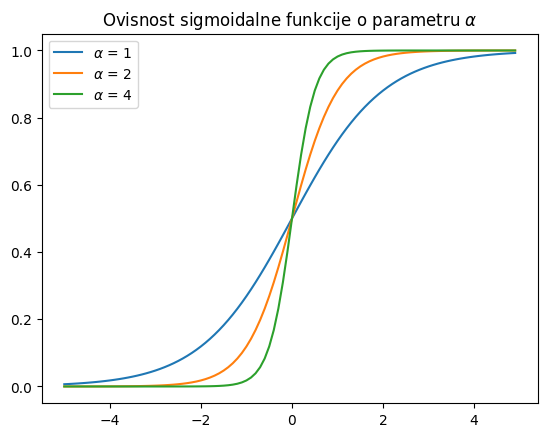

In [13]:
# Vaš kôd ovdje
def sigmoid_function(x, alpha = 1):
  return 1/(1+np.exp(-alpha*x))

x = np.arange(-5,5,0.1)
plt.plot(x,sigmoid_function(x), label="$\\alpha$ = 1")
plt.plot(x,sigmoid_function(x,2), label="$\\alpha$ = 2")
plt.plot(x,sigmoid_function(x,4),label="$\\alpha$ = 4")
plt.legend(loc="best")
plt.title("Ovisnost sigmoidalne funkcije o parametru $\\alpha$")
plt.show

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [33]:
from numpy import linalg

from sklearn.preprocessing import PolynomialFeatures
def lr_h(x, w):
  return sigmoid_function(np.dot(w,x.T))

def cross_entropy_error(X,y,w):
  rows,cols = X.shape
  err = 0
  for idx, x in enumerate(X):
    err = err + (-y[idx]*np.log(lr_h(x,w)) - (1 - y[idx])*np.log(1 - lr_h(x,w)))
  return err/rows

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
  poly = PolynomialFeatures(1)
  w_trace = np.array([])
  X = poly.fit_transform(X)
  rows,cols = X.shape
  w = np.zeros(cols)
  w_trace = np.empty((0, cols), float)
  w_trace = np.vstack([w_trace, w])
  while max_iter > 0:
    delta_w = np.zeros(cols)
    for idx,x in enumerate(X):
      h = lr_h(x, w)
      delta_w = delta_w - (h - y[idx])*x
    w[0] = w[0] + eta*delta_w[0]
    w[1:] = w[1:]*(1-eta*alpha) + eta*delta_w[1:]
    w_trace = np.vstack([w_trace, w])
    max_iter = max_iter - 1
    if abs(cross_entropy_error(X,y,w) - cross_entropy_error(X,y,w_trace[-2])) < epsilon:
      break
  if trace:
    return w,w_trace
  return w

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [15]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

Cross entropy error: 0.13521872720206746


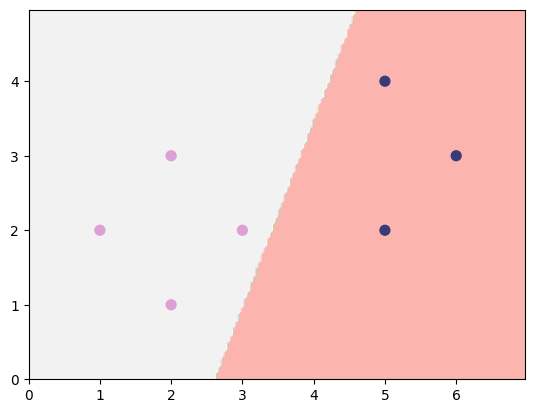

In [16]:
# Vaš kôd ovdje
trained_weights,trace_weights = lr_train(seven_X,seven_y,trace = True)

def lr_predict(x,w):
  x = np.insert(x, 0, 1)
  return sigmoid_function(np.dot(w,x.T))

plot_2d_clf_problem(seven_X,seven_y, lambda x : lr_predict(x,trained_weights) >= 0.5)
poly = PolynomialFeatures(1)
seven_X_transformed = poly.fit_transform(seven_X)
print("Cross entropy error: " + str(cross_entropy_error(seven_X_transformed,seven_y,trained_weights)))

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [17]:
from sklearn.metrics import zero_one_loss

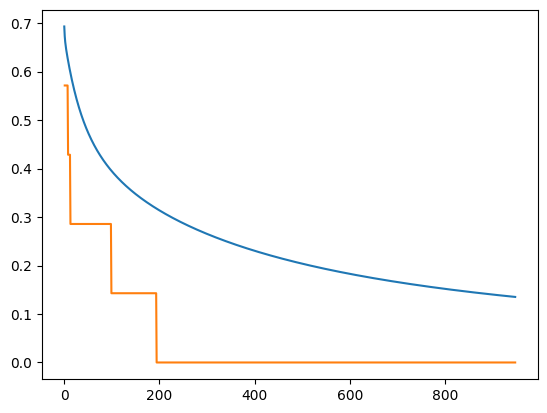

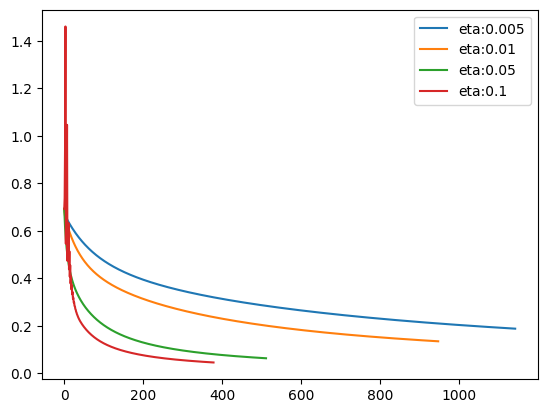

In [18]:
# Vaš kôd ovdje
cross_error_iter = []
zero_one_error_iter = []
poly = PolynomialFeatures(1)
X = poly.fit_transform(seven_X)
trained_weights,trace_weights = lr_train(seven_X,seven_y,trace = True)
for weight in trace_weights:
  y_pred = []
  for x in X:
    temp_y = lr_predict(x[1:],weight)
    if temp_y >= 0.5:
      temp_y = 1
    else:
      temp_y = 0
    y_pred.append(temp_y)
  cross_error_iter.append(cross_entropy_error(X,seven_y,weight))
  zero_one_error_iter.append(zero_one_loss(seven_y,y_pred))
arr = np.arange(0, len(trace_weights))
plt.plot(arr, cross_error_iter)
plt.plot(arr[1:], zero_one_error_iter[1:])
plt.show()



etas = [0.005, 0.01, 0.05, 0.1]
for eta in etas:
  cross_error_iter = []
  trained_weights,trace_weights = lr_train(seven_X,seven_y,trace = True, eta=eta)
  for weight in trace_weights:
    cross_error_iter.append(cross_entropy_error(X,seven_y,weight))
  arr = np.arange(0, len(trace_weights))
  plt.plot(arr, cross_error_iter, label=f'eta:{eta}')
plt.legend(loc="best")
plt.show()


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

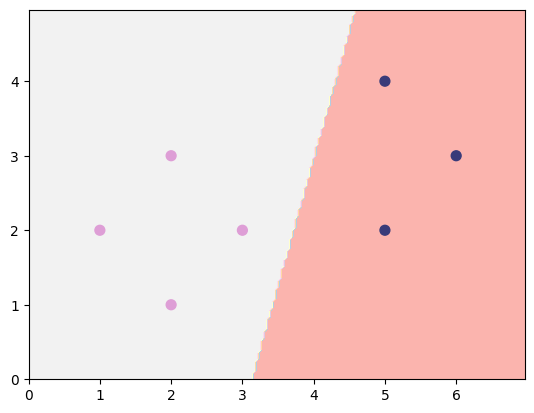

In [19]:
from sklearn.linear_model import LogisticRegression

# Vaš kôd ovdje

lgr = LogisticRegression(penalty='none',max_iter=2000).fit(seven_X,seven_y)
plot_2d_clf_problem(seven_X,seven_y, lambda x : lgr.predict(x))


### 4. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [20]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

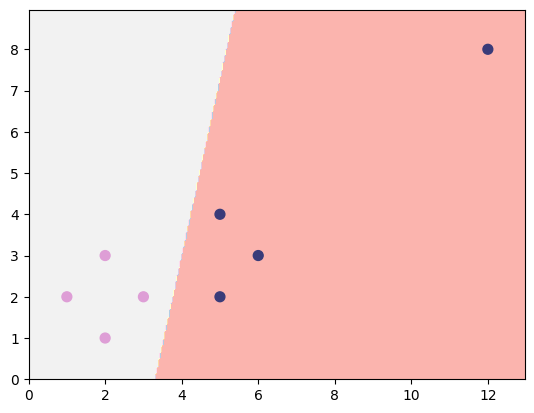

In [21]:
# Vaš kôd ovdje
lgr = LogisticRegression(penalty='none',max_iter=2000).fit(outlier_X,outlier_y)
plot_2d_clf_problem(outlier_X,outlier_y, lambda x : lgr.predict(x))

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

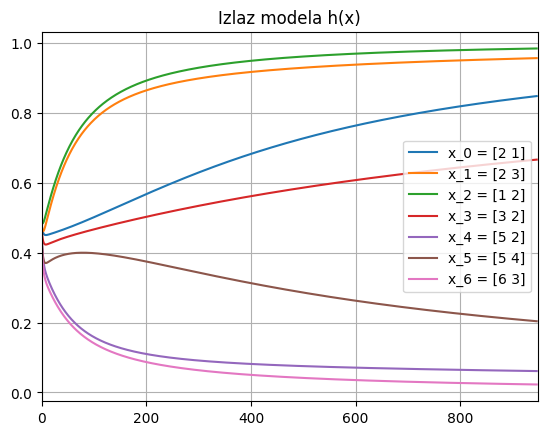

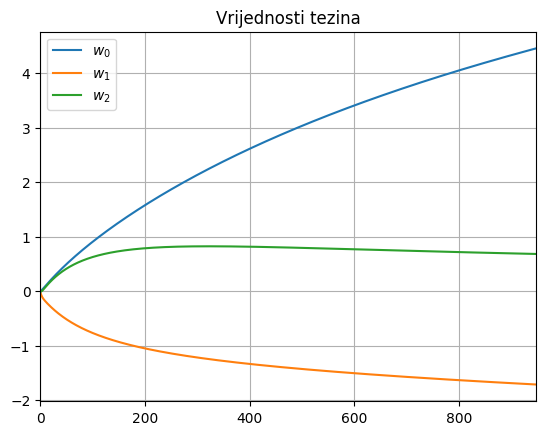

In [22]:
# Vaš kôd ovdje

# Vaš kôd ovdje
poly = PolynomialFeatures(1)
X = poly.fit_transform(seven_X)
trained_weights,trace_weights = lr_train(seven_X,seven_y,trace = True)
weights_b = []
predict_b = []
rows,cols = trace_weights.shape
for j in range(0,cols):
  weights_b.append(trace_weights[:,j])
h_all = []
for i in range(0,len(seven_X)):
  h = []

  for j in range(0, rows):
    h.append(lr_h(X[i],trace_weights[j]))
  h_all.append(h[1:])

for i in range(0, len(h_all)):
  plt.plot(h_all[i], label= "x_%d = " % i + str(seven_X[i]))
plt.title("Izlaz modela h(x)")
plt.legend(loc="best")
plt.xlim(0,rows)
plt.grid()
plt.show()

for i in range(0,len(weights_b)):
  plt.plot(weights_b[i], label="$w_%d$" % i)
plt.title("Vrijednosti tezina")
plt.legend(loc="best")
plt.xlim(0,rows)
plt.grid()
plt.show()

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [23]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

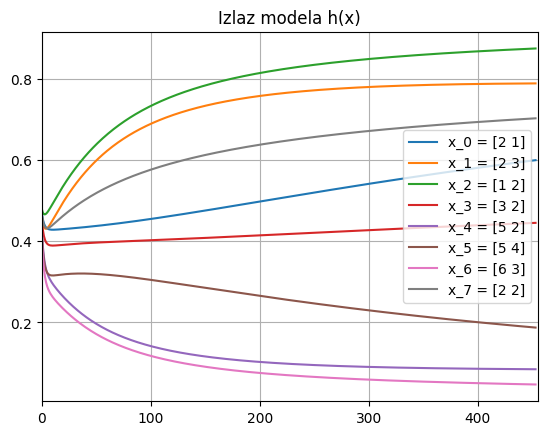

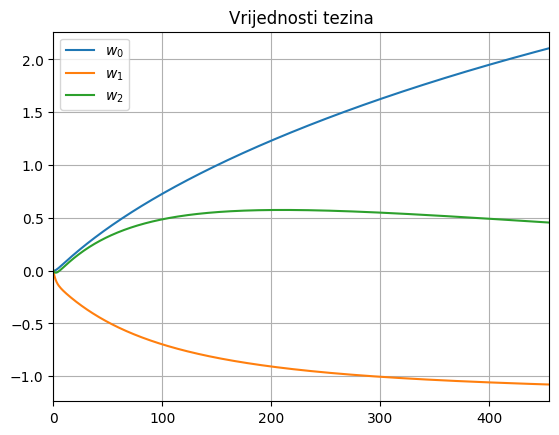

In [24]:
# Vaš kôd ovdje

poly = PolynomialFeatures(1)
X = poly.fit_transform(unsep_X)
trained_weights,trace_weights = lr_train(unsep_X,unsep_y,trace = True)
weights_b = []
predict_b = []
rows,cols = trace_weights.shape
for j in range(0,cols):
  weights_b.append(trace_weights[:,j])
h_all = []
for i in range(0,len(unsep_X)):
  h = []

  for j in range(0, rows):
    h.append(lr_h(X[i],trace_weights[j]))
  h_all.append(h[1:])

for i in range(0, len(h_all)):
  plt.plot(h_all[i], label= "x_%d = " % i + str(unsep_X[i]))
plt.title("Izlaz modela h(x)")
plt.legend(loc="best")
plt.xlim(0,rows)
plt.grid()
plt.show()

for i in range(0,len(weights_b)):
  plt.plot(weights_b[i], label="$w_%d$" % i)
plt.title("Vrijednosti tezina")
plt.legend(loc="best")
plt.grid()
plt.xlim(0,rows)
plt.show()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 5. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [25]:
from numpy.linalg import norm

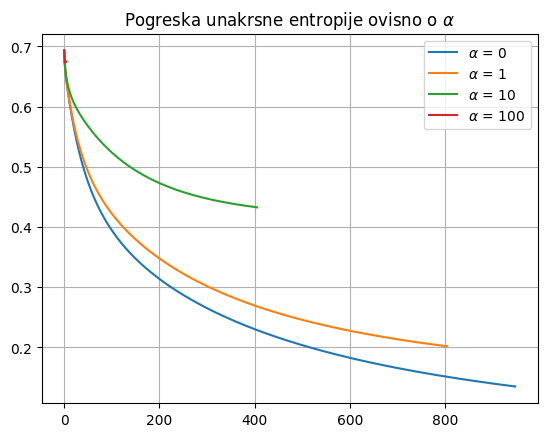

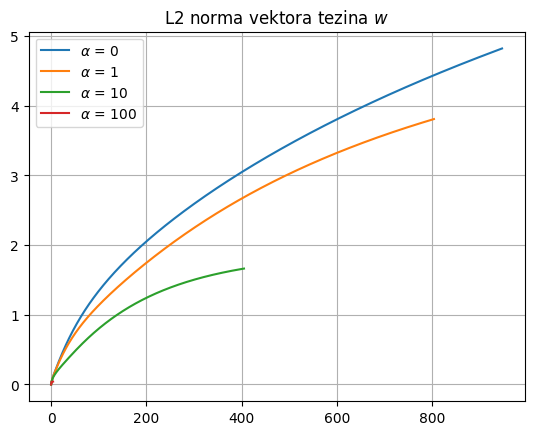

In [34]:
# Vaš kôd ovdje
alpha_5 = [0,1,10,100]

cross_err_all = []
L2_norm_all = []
poly = PolynomialFeatures(1)
X = poly.fit_transform(seven_X)
for alpha in alpha_5:
  cross_err = []
  L2_norm = []
  trained_weights,trace_weights = lr_train(seven_X,seven_y,trace = True,alpha=alpha)
  for weights in trace_weights:
    cross_err.append(cross_entropy_error(X,seven_y,weights))
    L2_norm.append(norm(weights))
  cross_err_all.append(cross_err)
  L2_norm_all.append(L2_norm)
for i in range (0,len(cross_err_all)):
  plt.plot(cross_err_all[i], label="$\\alpha$ = " + str(alpha_5[i]))
plt.legend(loc="best")
plt.grid()
plt.title("Pogreska unakrsne entropije ovisno o $\\alpha$")
plt.show()

for i in range(0,len(L2_norm_all)):
  plt.plot(L2_norm_all[i], label="$\\alpha$ = " + str(alpha_5[i]))
plt.legend(loc="best")
plt.grid()
plt.title("L2 norma vektora tezina $w$")
plt.show()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 6. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [27]:
from sklearn.preprocessing import PolynomialFeatures

#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))

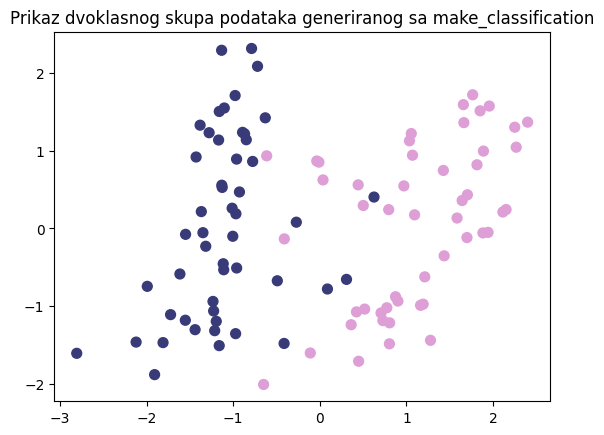

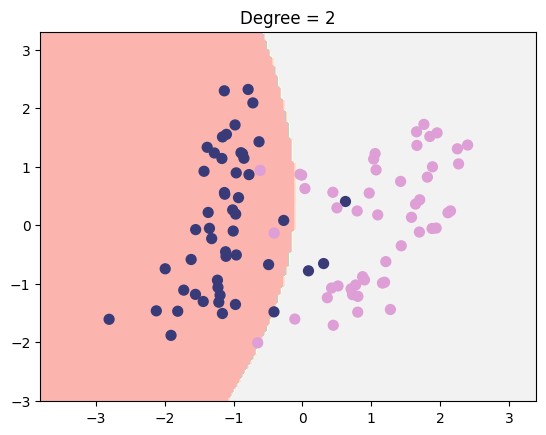

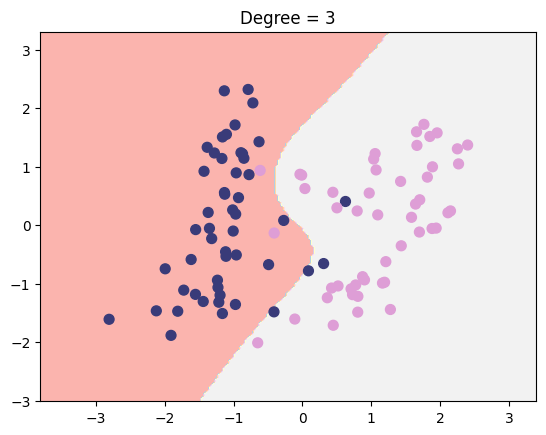

In [28]:
from sklearn.datasets import make_classification
X6, y6 = make_classification(n_samples=100, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=2)

plot_2d_clf_problem(X6, y6)
plt.title('Prikaz dvoklasnog skupa podataka generiranog sa make_classification')
plt.show()

degrees = [2,3]

for degree in degrees:
  poly = PolynomialFeatures(degree)
  X6_T = poly.fit_transform(X6)
  lrg = LogisticRegression().fit(X6_T,y6)
  plot_2d_clf_problem(X6, y6, lambda x : lrg.predict(poly.transform(x)))
  plt.title("Degree = " + str(degree))
  plt.show()

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?